
# Security Data Analysis Workshop
## Blue Team Focus: When to use AI/ML vs Basic Methods

This notebook demonstrates when to use simple statistical methods vs machine learning 
for cybersecurity analysis. Each module compares both approaches with realistic datasets.

## Setup and Imports ##

In [21]:
!pip install -r "https://raw.githubusercontent.com/AI-and-Security/old-soc-new-tricks/main/requirements-colab.txt"

In [22]:
import pandas as pd
import numpy as np
from datetime import datetime as dt, timedelta
import random
import time
import warnings
warnings.filterwarnings('ignore')


# ML libraries
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report


In [23]:

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
print("✅ Libraries imported successfully!")



✅ Libraries imported successfully!


In [24]:
DATA_DIR = "../data"

# ---
# Lesson 1: The Overwhelmed SOC Analyst
# **Persona**: Junior analyst drowning in thousands of alerts/entries in traffic logs. Note: Applicable to both threat hunters and SOC analysts. SOC does it after an alert to determine “investigation worthy” or not, threat hunters find the suspicious activity proactively.

# 
# **Scenario**: You have network traffic logs and need to quickly identify suspicious activity.
# 
# **Question**: Should you use Excel pivot tables or machine learning?

# 1.1 Import Network Traffic Dataset
# ---

In [25]:
traffic_df = pd.read_csv(f"{DATA_DIR}/network_traffic.csv")
traffic_df['timestamp'] = pd.to_datetime(traffic_df['timestamp'])

# Display sample
print("\n🔍 Sample of the data:")
display(traffic_df.head())


🔍 Sample of the data:


,timestamp,source_ip,destination_ip,destination_port,bytes,protocol
0,2025-08-08 20:05:51,192.168.1.70,10.0.4.29,80,593,TCP
1,2025-08-08 02:53:49,192.168.1.86,10.0.2.19,110,416,TCP
2,2025-08-08 01:07:48,192.168.1.30,10.0.1.44,110,1358,TCP
3,2025-08-08 01:15:43,192.168.1.44,10.0.3.30,25,93,TCP
4,2025-08-08 16:43:51,192.168.1.98,10.0.1.40,995,1251,TCP


## 1.2 Basic Analysis (Excel-Style in Python)
**Let's generate some basic statistics! You can use a tool like Excel for this**
**type of analysis, but you can also do this using python and pandas!**

Let's look for:
- Top talkers by bytes sent
- Unusual ports (simple frequency analysis)
- Large transfers (95th percentile threshold)
- Quick suspicious IP identification based on a pre-determined list of "suspicious" IPs

Pros:
- Very quick analysis
- Summary statistics
- Explainable!

Cons:
- No insight into complex behavior patterns
- Must pre-determine statistics you want to examine


In [26]:
def basic_traffic_analysis(df):
    """Basic analysis that mirrors Excel pivot tables and filters"""
    
    print("🔎 BASIC ANALYSIS (Excel-style approach)")
    print("=" * 50)
    
    # Analysis 1: Top talkers by bytes sent
    print("\n📈 TOP 10 SOURCES BY TOTAL BYTES:")
    top_sources = df.groupby('source_ip')['bytes'].agg(['sum', 'count', 'mean']).round(2)
    top_sources.columns = ['total_bytes', 'connections', 'avg_bytes']
    top_sources = top_sources.sort_values('total_bytes', ascending=False)
    print(top_sources.head(10))
    
    # Analysis 2: Unusual ports (simple frequency analysis)
    print("\n🔍 UNUSUAL PORTS (used ≤ 5 times):")
    port_counts = df['destination_port'].value_counts()
    unusual_ports = port_counts[port_counts <= 5]
    print(f"Found {len(unusual_ports)} unusual ports:")
    print(unusual_ports.head(10))
    
    # Analysis 3: Large transfers (95th percentile threshold)
    threshold = df['bytes'].quantile(0.95)
    large_transfers = df[df['bytes'] > threshold]
    print(f"\n📊 LARGE TRANSFERS (> {threshold:,.0f} bytes):")
    print(f"Found {len(large_transfers)} large transfers")
    
    large_by_source = large_transfers.groupby('source_ip').agg({
        'bytes': ['count', 'sum', 'max'],
        'destination_port': lambda x: list(x.unique())
    })
    large_by_source.columns = ['transfer_count', 'total_bytes', 'max_bytes', 'ports_used']
    print(large_by_source.head())
    
    # Quick suspicious IP identification
    suspicious_keywords = ['185.', '194.', '91.', '203.']
    external_ips = df[df['source_ip'].str.contains('|'.join(suspicious_keywords), na=False)]
    
    print(f"\n🚨 EXTERNAL SOURCE IPs:")
    if len(external_ips) > 0:
        ext_summary = external_ips.groupby('source_ip').agg({
            'bytes': ['count', 'sum'],
            'destination_port': lambda x: list(x.unique())
        })
        ext_summary.columns = ['connections', 'total_bytes', 'ports_used']
        print(ext_summary)
    else:
        print("No external IPs detected with basic pattern matching")
    
    return {
        'top_sources': top_sources,
        'unusual_ports': unusual_ports,
        'large_transfers': large_transfers,
        'external_ips': external_ips
    }

In [27]:
# Time the analysis
start_time = time.time()
basic_results = basic_traffic_analysis(traffic_df)
basic_time = time.time() - start_time

print(f"\n⏱️ Basic analysis completed in {basic_time:.2f} seconds")

🔎 BASIC ANALYSIS (Excel-style approach)

📈 TOP 10 SOURCES BY TOTAL BYTES:
                total_bytes  connections  avg_bytes
source_ip                                          
91.234.99.12      186521374         6779   27514.59
194.233.164.24    183246579         6665   27493.86
185.220.70.43     182402315         6670   27346.67
192.168.1.93        6146509         5398    1138.66
192.168.1.68        6116451         5411    1130.37
192.168.1.25        6103727         5395    1131.37
192.168.1.29        6091999         5377    1132.97
192.168.1.53        6074514         5482    1108.08
192.168.1.59        6072127         5357    1133.49
192.168.1.10        6066406         5387    1126.12

🔍 UNUSUAL PORTS (used ≤ 5 times):
Found 0 unusual ports:
Series([], Name: count, dtype: int64)

📊 LARGE TRANSFERS (> 8,311 bytes):
Found 24996 large transfers
               transfer_count  total_bytes  max_bytes  \
source_ip                                               
185.220.70.43            614

# 1.3 Machine Learning Analysis
**We will use an isolation forest to identify anomalies in this dataset.**

**What is an isolation forest, and why would we use this type of algorithm?**
The isolation forest algorithm is one ML algorithm which answers the question,
"Can you show me data points that are anomalous?" This algorithm is one example 
of a machine learning algorithm that is relatively efficient and low memory, 
which makes it a great algorithm for large datasets. 

**How This Applies to Security Data:**
Imagine you have 10,000 network connections. Most are normal:

Employee checking email
Someone browsing CNN.com
Automatic software updates

But one connection is weird:

Coming from an IP in North Korea
Downloading 50GB of customer data
At 3 AM on a Sunday

The weird connection is easy to isolate with just a few "cuts":

- "Is the IP from a normal location?" → No (isolates 90% of traffic)

- "Is the data volume normal?" → No (isolates 95% of remaining)

- "Is the time normal?" → No (isolated!)

The normal connections are hard to isolate - they blend in with thousands of others.
The "Forest" Part:
We don't just build one "decision tree" - we build many (a forest!). Each tree asks different random questions:

- Tree 1: "IP location?" → "Data volume?" → "Time of day?"

- Tree 2: "Port number?" → "Duration?" → "User type?"

- Tree 3: "Protocol?" → "Frequency?" → "Destination?"

If something is truly anomalous, it should be easy to isolate in MOST trees. If something only looks weird in one tree, it's probably just normal variation. This algorithm might be a good one for some use cases because...

✅ No Training Required: You don't need examples of "good" vs "bad" - it just finds things that don't fit the pattern.

✅ Finds Unknown Threats: Traditional security tools look for known bad stuff. Isolation Forest finds anything that's weird, including brand-new attacks.

✅ Fast & Scalable: Each tree is simple, so you can analyze millions of records quickly.

Pros:
- Allows you to discover and examine complex behavior patterns
- Incorporates context into your analysis
- Depending on the features extracted, can be explainable.

Cons:
- The performance of the Isolation Forest algorithm is highly dependent on the selection of its parameters.  
- More complex algorithm-- caution should be used if you don't know how it works!
- Depending on the features, can be hard to explain!
- May produce false positives/false negatives

In [28]:
def ml_traffic_analysis(df):
    """ML-based anomaly detection for network traffic"""
    
    print("🤖 MACHINE LEARNING ANALYSIS")
    print("=" * 50)
    
    # Feature engineering: Create behavioral profiles per source IP
    print("\n🔧 Creating behavioral features...")
    
    features = df.groupby('source_ip').agg({
        'bytes': ['sum', 'mean', 'std', 'max', 'count'],
        'destination_ip': 'nunique',
        'destination_port': ['nunique', lambda x: list(x)],
        'timestamp': lambda x: (x.max() - x.min()).total_seconds() / 3600  # session duration in hours
    })
    
    # Flatten column names
    features.columns = ['bytes_sum', 'bytes_mean', 'bytes_std', 'bytes_max', 'connection_count', 
                       'unique_destinations', 'unique_ports', 'ports_list', 'session_duration_hours']
    
    # Fill NaN values
    features['bytes_std'] = features['bytes_std'].fillna(0)
    
    # Add derived features
    features['avg_bytes_per_connection'] = features['bytes_sum'] / features['connection_count']
    features['port_diversity'] = features['unique_ports'] / features['connection_count']
    
    # Check for suspicious ports based on pre-determined list of ports
    suspicious_ports = [1337, 4444, 8080, 9999, 31337, 6666]
    features['has_suspicious_ports'] = features['ports_list'].apply(
        lambda ports: any(port in suspicious_ports for port in ports)
    ).astype(int)
    
    print(f"✅ Created features for {len(features)} unique source IPs")
    print("\n📊 Feature summary:")
    display(features[['bytes_sum', 'connection_count', 'unique_destinations', 'unique_ports', 'has_suspicious_ports']].describe())
    
    # Prepare features for ML (exclude non-numeric columns)
    ml_features = features.drop(['ports_list'], axis=1)
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(ml_features)
    
    # Apply Isolation Forest for anomaly detection
    print("\n🔍 Applying Isolation Forest anomaly detection...")
    iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators=100)
    anomaly_labels = iso_forest.fit_predict(features_scaled)
    
    # Get anomaly scores
    anomaly_scores = iso_forest.decision_function(features_scaled)
    
    # Add results back to features
    features['anomaly_label'] = anomaly_labels
    features['anomaly_score'] = anomaly_scores
    
    # Analyze anomalies
    anomalies = features[features['anomaly_label'] == -1].sort_values('anomaly_score')
    
    print(f"\n🚨 ANOMALOUS SOURCE IPs DETECTED: {len(anomalies)}")
    print("\nTop 5 most anomalous IPs:")
    
    for i, (ip, row) in enumerate(anomalies.head().iterrows()):
        print(f"\n{i+1}. {ip} (anomaly score: {row['anomaly_score']:.3f})")
        print(f"   📊 Total bytes: {row['bytes_sum']:,}")
        print(f"   🔗 Connections: {row['connection_count']}")
        print(f"   🎯 Unique destinations: {row['unique_destinations']}")
        print(f"   🔌 Unique ports: {row['unique_ports']}")
        print(f"   ⚠️  Has suspicious ports: {'Yes' if row['has_suspicious_ports'] else 'No'}")
        print(f"   🕐 Session duration: {row['session_duration_hours']:.1f} hours")
        
        # Show actual ports used
        actual_data = df[df['source_ip'] == ip]
        ports_used = actual_data['destination_port'].value_counts().head(5)
        cast_ports = {key: int(value) for key, value in dict(ports_used).items()}
        print(f"   🔌 Top ports: {cast_ports}")
    
    return {
        'features': features,
        'anomalies': anomalies,
        'model': iso_forest,
        'scaler': scaler
    }

In [29]:
# Time the ML analysis
start_time = time.time()
ml_results = ml_traffic_analysis(traffic_df)
ml_time = time.time() - start_time

print(f"\n⏱️ ML analysis completed in {ml_time:.2f} seconds")

🤖 MACHINE LEARNING ANALYSIS

🔧 Creating behavioral features...
✅ Created features for 93 unique source IPs

📊 Feature summary:


,bytes_sum,connection_count,unique_destinations,unique_ports,has_suspicious_ports
count,9.300000e+01,93.000000,93.000000,93.000000,93.0
mean,1.165205e+07,5376.344086,244.806452,13.709677,1.0
std,3.164915e+07,254.950272,15.640150,1.598781,0.0
min,5.506161e+06,5142.000000,160.000000,5.000000,1.0
25%,5.841450e+06,5284.000000,246.000000,14.000000,1.0
50%,5.921868e+06,5342.000000,248.000000,14.000000,1.0
75%,6.008240e+06,5394.000000,249.000000,14.000000,1.0
max,1.865214e+08,6779.000000,250.000000,14.000000,1.0



🔍 Applying Isolation Forest anomaly detection...

🚨 ANOMALOUS SOURCE IPs DETECTED: 10

Top 5 most anomalous IPs:

1. 91.234.99.12 (anomaly score: -0.314)
   📊 Total bytes: 186,521,374
   🔗 Connections: 6779
   🎯 Unique destinations: 160
   🔌 Unique ports: 5
   ⚠️  Has suspicious ports: Yes
   🕐 Session duration: 24.0 hours
   🔌 Top ports: {1337: 1423, 9999: 1360, 8080: 1354, 4444: 1349, 31337: 1293}

2. 185.220.70.43 (anomaly score: -0.279)
   📊 Total bytes: 182,402,315
   🔗 Connections: 6670
   🎯 Unique destinations: 160
   🔌 Unique ports: 5
   ⚠️  Has suspicious ports: Yes
   🕐 Session duration: 24.0 hours
   🔌 Top ports: {4444: 1344, 31337: 1342, 1337: 1334, 8080: 1330, 9999: 1320}

3. 194.233.164.24 (anomaly score: -0.273)
   📊 Total bytes: 183,246,579
   🔗 Connections: 6665
   🎯 Unique destinations: 160
   🔌 Unique ports: 5
   ⚠️  Has suspicious ports: Yes
   🕐 Session duration: 24.0 hours
   🔌 Top ports: {31337: 1373, 4444: 1353, 8080: 1323, 1337: 1313, 9999: 1303}

4. 192.168.1

# 1.4 Comparison and Analysis

In [30]:
def compare_methods_module1():
    """Compare the effectiveness of basic vs ML methods"""
    
    print("📊 METHOD COMPARISON - MODULE 1")
    print("=" * 50)
    
    # Get the actual suspicious IPs from our data generation
    actual_suspicious = ['185.220.70.43', '194.233.164.24', '91.234.99.12']
    
    # Basic method results
    basic_suspicious = basic_results['external_ips']['source_ip'].unique() if len(basic_results['external_ips']) > 0 else []
    
    # ML method results
    ml_suspicious = ml_results['anomalies'].index.tolist()
    
    print(f"🎯 ACTUAL SUSPICIOUS IPs: {actual_suspicious}")
    print(f"🔍 BASIC METHOD found: {list(basic_suspicious)}")
    print(f"🤖 ML METHOD found: {ml_suspicious[:5]}...")  # Show top 5
    
    # Calculate detection rates
    basic_detected = len(set(basic_suspicious) & set(actual_suspicious))
    ml_detected = len(set(ml_suspicious) & set(actual_suspicious))
    
    print(f"\n📈 DETECTION RESULTS:")
    print(f"   Basic method detected: {basic_detected}/{len(actual_suspicious)} suspicious IPs")
    print(f"   ML method detected: {ml_detected}/{len(actual_suspicious)} suspicious IPs")
    
    # Show timing comparison
    print(f"\n⏱️ TIMING COMPARISON:")
    print(f"   Basic method: {basic_time:.2f} seconds")
    print(f"   ML method: {ml_time:.2f} seconds")
    print(f"   Speed difference: {ml_time/basic_time:.1f}x slower. \n\nFor basic analysis on relatively small datasets, \nthe two methods have similar runtimes, but for larger datasets, ML methods may take longer. \nIt can also take a while to fine-tune the features extracted and to work through any false positives!")
    
    # When to use each method
    print(f"\n💡 RECOMMENDATIONS:")
    print("✅ Use BASIC METHOD when:")
    print("   • You need results very quickly")
    print("   • Looking for known bad indicators")
    print("   • Need explainable results for management")
    
    print("\n✅ Use ML METHOD when:")
    print("   • Unknown threat patterns")
    print("   • Building automated detection")
    print("   • Complex behavioral analysis needed")

compare_methods_module1()

📊 METHOD COMPARISON - MODULE 1
🎯 ACTUAL SUSPICIOUS IPs: ['185.220.70.43', '194.233.164.24', '91.234.99.12']
🔍 BASIC METHOD found: ['91.234.99.12', '194.233.164.24', '185.220.70.43']
🤖 ML METHOD found: ['91.234.99.12', '185.220.70.43', '194.233.164.24', '192.168.1.98', '192.168.1.24']...

📈 DETECTION RESULTS:
   Basic method detected: 3/3 suspicious IPs
   ML method detected: 3/3 suspicious IPs

⏱️ TIMING COMPARISON:
   Basic method: 0.36 seconds
   ML method: 0.56 seconds
   Speed difference: 1.6x slower. 

For basic analysis on relatively small datasets, 
the two methods have similar runtimes, but for larger datasets, ML methods may take longer. 
It can also take a while to fine-tune the features extracted and to work through any false positives!

💡 RECOMMENDATIONS:
✅ Use BASIC METHOD when:
   • You need results very quickly
   • Looking for known bad indicators
   • Need explainable results for management

✅ Use ML METHOD when:
   • Unknown threat patterns
   • Building automated det

# ---
# Lesson 2: The Incident Responder Under Pressure
# **Persona**: IR team member with 30 minutes to determine if an alert is real
# 
# **Scenario**: Authentication logs showing potential brute force attacks
# 
# **Question**: Pivot tables or behavioral modeling?

# 2.1 Import Authentication Dataset

In [31]:
auth_df = pd.read_csv(f"{DATA_DIR}/auth_logs.csv")
auth_df['timestamp'] = pd.to_datetime(auth_df['timestamp'])

# Show sample
print("\n🔍 Sample of the data:")
display(auth_df.head())

# Quick overview
print(f"\n📈 Event breakdown:")
print(auth_df['event_type'].value_counts())



🔍 Sample of the data:


,timestamp,username,source_ip,event_type,service
0,2025-08-07 05:52:51,user068,192.168.4.45,login_success,ssh
1,2025-08-07 05:52:57,user102,192.168.1.39,login_failure,rdp
2,2025-08-07 05:53:02,user051,192.168.1.31,login_success,rdp
3,2025-08-07 05:53:02,user103,192.168.3.36,login_success,rdp
4,2025-08-07 05:53:02,user060,192.168.1.10,login_success,rdp



📈 Event breakdown:
event_type
login_success    7000
login_failure    2279
Name: count, dtype: int64


In [32]:
# ## 2.2 Basic Analysis (Excel-Style)
# **⏱️ Time Limit: 5 minutes**

# %%
def basic_auth_analysis(df):
    """Basic authentication analysis using simple aggregations"""
    
    print("🔎 BASIC AUTH ANALYSIS (Excel-style)")
    print("=" * 50)
    
    # Analysis 1: Failed login attempts by source IP
    failed_logins = df[df['event_type'] == 'login_failure']
    
    print(f"\n📊 FAILED LOGIN SUMMARY:")
    print(f"Total failed logins: {len(failed_logins):,}")
    print(f"Unique source IPs: {failed_logins['source_ip'].nunique()}")
    print(f"Unique usernames targeted: {failed_logins['username'].nunique()}")
    
    # Top IPs by failed attempts
    ip_failures = failed_logins.groupby('source_ip').agg({
        'username': ['count', 'nunique'],
        'timestamp': ['min', 'max']
    })
    ip_failures.columns = ['total_failures', 'unique_users_targeted', 'first_attempt', 'last_attempt']
    ip_failures['attack_duration_minutes'] = (
        ip_failures['last_attempt'] - ip_failures['first_attempt']
    ).dt.total_seconds() / 60
    
    ip_failures = ip_failures.sort_values('total_failures', ascending=False)
    
    print(f"\n🎯 TOP 10 SOURCE IPs BY FAILED ATTEMPTS:")
    display(ip_failures.head(10))
    
    # Simple brute force detection (threshold-based)
    brute_force_threshold = 20
    potential_attackers = ip_failures[ip_failures['total_failures'] >= brute_force_threshold]
    
    print(f"\n🚨 POTENTIAL BRUTE FORCE ATTACKERS (≥{brute_force_threshold} failures):")
    if len(potential_attackers) > 0:
        for ip, row in potential_attackers.iterrows():
            print(f"\n📍 {ip}:")
            print(f"   💥 Total failures: {row['total_failures']}")
            print(f"   👤 Users targeted: {row['unique_users_targeted']}")
            print(f"   ⏱️  Attack duration: {row['attack_duration_minutes']:.1f} minutes")
            
            # Show most targeted usernames for this IP
            ip_targets = failed_logins[failed_logins['source_ip'] == ip]['username'].value_counts().head(5)
            print(f"   🎯 Top targets: {dict(ip_targets)}")
    else:
        print("No IPs exceed the brute force threshold")
    
    # Time-based analysis
    failed_logins['hour'] = failed_logins['timestamp'].dt.hour
    hourly_failures = failed_logins.groupby('hour').size()
    
    print(f"\n🕐 FAILED LOGINS BY HOUR:")
    peak_hour = hourly_failures.idxmax()
    print(f"Peak hour: {peak_hour}:00 with {hourly_failures[peak_hour]} failures")
    
    return {
        'ip_failures': ip_failures,
        'potential_attackers': potential_attackers,
        'hourly_failures': hourly_failures,
        'failed_logins': failed_logins
    }

# Time the basic analysis
start_time = time.time()
basic_auth_results = basic_auth_analysis(auth_df)
basic_auth_time = time.time() - start_time

print(f"\n⏱️ Basic analysis completed in {basic_auth_time:.2f} seconds")

# %% [markdown]
# ## 2.3 Machine Learning Analysis

# %%
def ml_auth_analysis(df):
    """ML-based authentication analysis using behavioral modeling"""
    
    print("🤖 ML AUTHENTICATION ANALYSIS")
    print("=" * 50)
    
    # Create time windows for behavioral analysis
    print("\n🔧 Creating behavioral features with time windows...")
    
    # Use 10-minute time windows
    df['time_window'] = df['timestamp'].dt.floor('10min')
    
    # Create features per IP per time window
    window_features = df.groupby(['source_ip', 'time_window']).agg({
        'username': ['nunique', 'count'],
        'event_type': [lambda x: (x == 'login_failure').sum(), 
                      lambda x: (x == 'login_success').sum()],
        'service': 'nunique'
    })
    
    window_features.columns = ['unique_users', 'total_attempts', 'failures', 'successes', 'unique_services']
    
    # Calculate rates and ratios
    window_features['failure_rate'] = window_features['failures'] / window_features['total_attempts']
    window_features['attempts_per_minute'] = window_features['total_attempts'] / 10  # 10-minute windows
    window_features['user_diversity'] = window_features['unique_users'] / window_features['total_attempts']
    
    # Fill NaN values
    window_features = window_features.fillna(0)
    
    # Add IP-level behavioral features
    ip_features = df.groupby('source_ip').agg({
        'username': 'nunique',
        'timestamp': ['count', lambda x: (x.max() - x.min()).total_seconds() / 3600],
        'event_type': [lambda x: (x == 'login_failure').sum(), 
                      lambda x: (x == 'login_success').sum()]
    })
    
    ip_features.columns = ['total_unique_users', 'total_attempts', 'session_duration_hours', 
                          'total_failures', 'total_successes']
    ip_features['overall_failure_rate'] = ip_features['total_failures'] / ip_features['total_attempts']
    
    # Check if IP is external (simple heuristic)
    ip_features['is_external'] = ~ip_features.index.str.startswith('192.168.')
    ip_features['is_external'] = ip_features['is_external'].astype(int)
    
    print(f"✅ Created features for {len(window_features)} time windows across {len(ip_features)} IPs")
    
    # Apply clustering to find unusual patterns in time windows
    print("\n🔍 Applying DBSCAN clustering on time window features...")
    
    # Select features for clustering
    cluster_features = window_features[['unique_users', 'total_attempts', 'failure_rate', 
                                      'attempts_per_minute', 'user_diversity']].copy()
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(cluster_features)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=4)
    clusters = dbscan.fit_predict(features_scaled)
    
    # Add cluster labels
    window_features['cluster'] = clusters
    
    # Analyze outliers (cluster -1)
    outliers = window_features[window_features['cluster'] == -1]
    
    print(f"\n🚨 ANOMALOUS TIME WINDOWS DETECTED: {len(outliers)}")
    
    # Group outliers by IP for analysis
    outlier_ips = outliers.groupby(level='source_ip').agg({
        'total_attempts': ['sum', 'max'],
        'failures': ['sum', 'max'],
        'failure_rate': 'mean',
        'attempts_per_minute': 'max',
        'unique_users': 'max'
    })
    
    outlier_ips.columns = ['total_attempts', 'max_attempts_per_window', 'total_failures', 
                          'max_failures_per_window', 'avg_failure_rate', 
                          'max_attempts_per_minute', 'max_users_per_window']
    
    # Sort by severity
    outlier_ips['severity_score'] = (
        outlier_ips['max_attempts_per_minute'] * 0.4 +
        outlier_ips['avg_failure_rate'] * 0.3 +
        outlier_ips['max_users_per_window'] * 0.3
    )
    
    outlier_ips = outlier_ips.sort_values('severity_score', ascending=False)
    
    print(f"\n🎯 TOP SUSPICIOUS IPs BY ML ANALYSIS:")
    
    for i, (ip, row) in enumerate(outlier_ips.head().iterrows()):
        print(f"\n{i+1}. {ip} (severity score: {row['severity_score']:.2f})")
        print(f"   💥 Total attempts: {row['total_attempts']}")
        print(f"   📈 Max attempts/minute: {row['max_attempts_per_minute']:.1f}")
        print(f"   ❌ Average failure rate: {row['avg_failure_rate']:.2%}")
        print(f"   👥 Max users targeted in one window: {row['max_users_per_window']}")
        
        # Show timeline for this IP
        ip_data = df[df['source_ip'] == ip]
        print(f"   📅 Active period: {ip_data['timestamp'].min()} to {ip_data['timestamp'].max()}")
        
        # Show most common usernames
        top_users = ip_data['username'].value_counts().head(3)
        print(f"   🎯 Top targets: {dict(top_users)}")
    
    return {
        'window_features': window_features,
        'ip_features': ip_features,
        'outliers': outliers,
        'outlier_ips': outlier_ips,
        'clusters': clusters
    }

🔎 BASIC AUTH ANALYSIS (Excel-style)

📊 FAILED LOGIN SUMMARY:
Total failed logins: 2,279
Unique source IPs: 164
Unique usernames targeted: 155

🎯 TOP 10 SOURCE IPs BY FAILED ATTEMPTS:


,total_failures,unique_users_targeted,first_attempt,last_attempt,attack_duration_minutes
source_ip,,,,,
192.0.2.123,118,31,2025-08-07 06:52:49,2025-08-07 07:09:59,17.166667
198.51.100.42,78,26,2025-08-07 10:52:49,2025-08-07 11:04:09,11.333333
203.0.113.15,50,20,2025-08-07 09:52:49,2025-08-07 10:00:09,7.333333
185.199.108.153,33,16,2025-08-07 09:52:49,2025-08-07 09:57:39,4.833333
192.168.1.39,21,21,2025-08-07 05:52:57,2025-08-07 12:59:46,426.816667
192.168.3.30,21,21,2025-08-07 05:54:01,2025-08-07 13:51:46,477.750000
192.168.2.33,20,20,2025-08-07 06:14:30,2025-08-07 12:59:08,404.633333
192.168.3.36,20,19,2025-08-07 05:53:53,2025-08-07 13:44:38,470.750000
192.168.1.21,19,17,2025-08-07 05:58:41,2025-08-07 13:50:54,472.216667



🚨 POTENTIAL BRUTE FORCE ATTACKERS (≥20 failures):

📍 192.0.2.123:
   💥 Total failures: 118
   👤 Users targeted: 31
   ⏱️  Attack duration: 17.2 minutes
   🎯 Top targets: {'admin': np.int64(17), 'user': np.int64(12), 'test': np.int64(11), 'guest': np.int64(11), 'root': np.int64(10)}

📍 198.51.100.42:
   💥 Total failures: 78
   👤 Users targeted: 26
   ⏱️  Attack duration: 11.3 minutes
   🎯 Top targets: {'admin': np.int64(10), 'root': np.int64(9), 'guest': np.int64(8), 'test': np.int64(8), 'user': np.int64(7)}

📍 203.0.113.15:
   💥 Total failures: 50
   👤 Users targeted: 20
   ⏱️  Attack duration: 7.3 minutes
   🎯 Top targets: {'administrator': np.int64(8), 'guest': np.int64(6), 'root': np.int64(6), 'test': np.int64(4), 'user019': np.int64(4)}

📍 185.199.108.153:
   💥 Total failures: 33
   👤 Users targeted: 16
   ⏱️  Attack duration: 4.8 minutes
   🎯 Top targets: {'test': np.int64(4), 'root': np.int64(4), 'administrator': np.int64(3), 'guest': np.int64(3), 'user': np.int64(3)}

📍 192.168

In [33]:
# Time the ML analysis
start_time = time.time()
ml_auth_results = ml_auth_analysis(auth_df)
ml_auth_time = time.time() - start_time

print(f"\n⏱️ ML analysis completed in {ml_auth_time:.2f} seconds")

🤖 ML AUTHENTICATION ANALYSIS

🔧 Creating behavioral features with time windows...
✅ Created features for 5317 time windows across 164 IPs

🔍 Applying DBSCAN clustering on time window features...

🚨 ANOMALOUS TIME WINDOWS DETECTED: 17

🎯 TOP SUSPICIOUS IPs BY ML ANALYSIS:

1. 192.0.2.123 (severity score: 10.88)
   💥 Total attempts: 118.0
   📈 Max attempts/minute: 7.7
   ❌ Average failure rate: 100.00%
   👥 Max users targeted in one window: 25.0
   📅 Active period: 2025-08-07 06:52:49 to 2025-08-07 07:09:59
   🎯 Top targets: {'admin': np.int64(17), 'user': np.int64(12), 'test': np.int64(11)}

2. 198.51.100.42 (severity score: 10.40)
   💥 Total attempts: 78.0
   📈 Max attempts/minute: 6.5
   ❌ Average failure rate: 100.00%
   👥 Max users targeted in one window: 25.0
   📅 Active period: 2025-08-07 10:52:49 to 2025-08-07 11:04:09
   🎯 Top targets: {'admin': np.int64(10), 'root': np.int64(9), 'guest': np.int64(8)}

3. 203.0.113.15 (severity score: 8.26)
   💥 Total attempts: 49.0
   📈 Max att

In [34]:
def compare_methods_module2():

# %% [markdown]
# ## 🔬 **Deep Dive: Method Comparison Analysis**
# 
# Let's create a detailed comparison of how well each method actually performed on our authentication data.

# %%
    def detailed_method_comparison():
        """Comprehensive comparison of Excel-style vs ML methods"""
        
        print("🔬 DETAILED METHOD COMPARISON ANALYSIS")
        print("=" * 60)
        
        # Get the actual suspicious IPs from our data generation
        actual_attackers = ['203.0.113.15', '198.51.100.42', '192.0.2.123', '185.199.108.153']
        
        # Basic method results
        basic_suspicious = basic_auth_results['potential_attackers'].index.tolist()
        
        # ML method results
        ml_suspicious = ml_auth_results['outlier_ips'].index.tolist()
        
        # Create comparison DataFrame
        comparison_data = []
        
        # Analyze each actual attacker
        for ip in actual_attackers:
            basic_detected = ip in basic_suspicious
            ml_detected = ip in ml_suspicious
            
            # Get actual behavior data
            ip_data = auth_df[auth_df['source_ip'] == ip]
            total_attempts = len(ip_data)
            failures = len(ip_data[ip_data['event_type'] == 'login_failure'])
            unique_users = ip_data['username'].nunique()
            time_span = (ip_data['timestamp'].max() - ip_data['timestamp'].min()).total_seconds() / 60
            
            comparison_data.append({
                'ip': ip,
                'actual_attacker': True,
                'basic_detected': basic_detected,
                'ml_detected': ml_detected,
                'total_attempts': total_attempts,
                'failures': failures,
                'failure_rate': failures / total_attempts if total_attempts > 0 else 0,
                'unique_users': unique_users,
                'time_span_minutes': time_span
            })
        
        # Analyze false positives
        all_detected = set(basic_suspicious + ml_suspicious)
        false_positives = all_detected - set(actual_attackers)
        
        for ip in false_positives:
            basic_detected = ip in basic_suspicious
            ml_detected = ip in ml_suspicious
            
            # Get behavior data
            ip_data = auth_df[auth_df['source_ip'] == ip]
            total_attempts = len(ip_data)
            failures = len(ip_data[ip_data['event_type'] == 'login_failure'])
            unique_users = ip_data['username'].nunique()
            time_span = (ip_data['timestamp'].max() - ip_data['timestamp'].min()).total_seconds() / 60
            
            comparison_data.append({
                'ip': ip,
                'actual_attacker': False,
                'basic_detected': basic_detected,
                'ml_detected': ml_detected,
                'total_attempts': total_attempts,
                'failures': failures,
                'failure_rate': failures / total_attempts if total_attempts > 0 else 0,
                'unique_users': unique_users,
                'time_span_minutes': time_span
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        
        print("📊 DETECTION RESULTS SUMMARY:")
        print(comparison_df[['ip', 'actual_attacker', 'basic_detected', 'ml_detected', 'failures', 'unique_users']].to_string(index=False))
        
        # Calculate metrics
        actual_positives = comparison_df[comparison_df['actual_attacker'] == True]
        
        # True Positives
        basic_tp = len(actual_positives[(actual_positives['basic_detected'] == True)])
        ml_tp = len(actual_positives[(actual_positives['ml_detected'] == True)])
        
        # False Negatives  
        basic_fn = len(actual_positives[(actual_positives['basic_detected'] == False)])
        ml_fn = len(actual_positives[(actual_positives['ml_detected'] == False)])
        
        # False Positives
        basic_fp = len(comparison_df[(comparison_df['actual_attacker'] == False) & (comparison_df['basic_detected'] == True)])
        ml_fp = len(comparison_df[(comparison_df['actual_attacker'] == False) & (comparison_df['ml_detected'] == True)])
        
        # True Negatives (all other IPs that weren't flagged)
        total_unique_ips = auth_df['source_ip'].nunique()
        basic_tn = total_unique_ips - basic_tp - basic_fn - basic_fp
        ml_tn = total_unique_ips - ml_tp - ml_fn - ml_fp
        
        print(f"\n📈 CONFUSION MATRIX ANALYSIS:")
        print(f"Total unique IPs in dataset: {total_unique_ips}")
        print(f"Actual attackers: {len(actual_attackers)}")
        
        print(f"\n🔍 BASIC METHOD:")
        print(f"  ✅ True Positives (attackers caught): {basic_tp}")
        print(f"  ❌ False Negatives (attackers missed): {basic_fn}")
        print(f"  ⚠️  False Positives (innocent flagged): {basic_fp}")
        print(f"  ✅ True Negatives (innocent ignored): {basic_tn}")
        
        print(f"\n🤖 ML METHOD:")
        print(f"  ✅ True Positives (attackers caught): {ml_tp}")
        print(f"  ❌ False Negatives (attackers missed): {ml_fn}")
        print(f"  ⚠️  False Positives (innocent flagged): {ml_fp}")
        print(f"  ✅ True Negatives (innocent ignored): {ml_tn}")
        
        # Calculate performance metrics
        def calculate_metrics(tp, fp, fn, tn):
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
            return precision, recall, f1, accuracy
        
        basic_precision, basic_recall, basic_f1, basic_accuracy = calculate_metrics(basic_tp, basic_fp, basic_fn, basic_tn)
        ml_precision, ml_recall, ml_f1, ml_accuracy = calculate_metrics(ml_tp, ml_fp, ml_fn, ml_tn)
        
        print(f"\n🎯 PERFORMANCE METRICS:")
        
        print(f"\n📊 BASIC METHOD SCORES:")
        print(f"  Precision (when I say attacker, how often am I right?): {basic_precision:.2%}")
        print(f"  Recall (what % of attackers did I catch?): {basic_recall:.2%}")
        print(f"  F1-Score (balanced measure): {basic_f1:.3f}")
        print(f"  Accuracy (overall correctness): {basic_accuracy:.2%}")
        
        print(f"\n🤖 ML METHOD SCORES:")
        print(f"  Precision (when I say attacker, how often am I right?): {ml_precision:.2%}")
        print(f"  Recall (what % of attackers did I catch?): {ml_recall:.2%}")
        print(f"  F1-Score (balanced measure): {ml_f1:.3f}")
        print(f"  Accuracy (overall correctness): {ml_accuracy:.2%}")
        
        # Visual comparison
        metrics_comparison = pd.DataFrame({
            'Method': ['Basic (Excel-style)', 'ML (Behavioral)'],
            'Precision': [basic_precision, ml_precision],
            'Recall': [basic_recall, ml_recall],
            'F1-Score': [basic_f1, ml_f1],
            'Accuracy': [basic_accuracy, ml_accuracy]
        })
        
        print(f"\n📊 SIDE-BY-SIDE COMPARISON:")
        display(metrics_comparison.round(3))
        
        # Analyze WHY differences occurred
        print(f"\n🤔 WHY THE DIFFERENCES?")
        
        # Look at false positives
        if basic_fp > 0 or ml_fp > 0:
            print(f"\n⚠️  FALSE POSITIVE ANALYSIS:")
            false_pos_ips = comparison_df[comparison_df['actual_attacker'] == False]
            
            for _, row in false_pos_ips.iterrows():
                if row['basic_detected'] or row['ml_detected']:
                    print(f"\n  📍 {row['ip']} (probably legitimate user with issues):")
                    print(f"    Basic method flagged: {'Yes' if row['basic_detected'] else 'No'}")
                    print(f"    ML method flagged: {'Yes' if row['ml_detected'] else 'No'}")
                    print(f"    Behavior: {row['failures']} failures, {row['unique_users']} users, {row['time_span_minutes']:.1f} min span")
                    
                    # Explain why each method flagged it
                    if row['basic_detected']:
                        print(f"    🔍 Basic flagged because: {row['failures']} failures exceeded threshold")
                    if row['ml_detected']:
                        print(f"    🤖 ML flagged because: behavioral pattern differed from normal users")
        
        # Look at missed attackers
        missed_attackers = comparison_df[(comparison_df['actual_attacker'] == True) & 
                                    ((comparison_df['basic_detected'] == False) | 
                                        (comparison_df['ml_detected'] == False))]
        
        if len(missed_attackers) > 0:
            print(f"\n❌ MISSED ATTACKER ANALYSIS:")
            for _, row in missed_attackers.iterrows():
                print(f"\n  🚨 {row['ip']} (actual attacker that was missed):")
                print(f"    Basic method missed: {'Yes' if not row['basic_detected'] else 'No'}")
                print(f"    ML method missed: {'Yes' if not row['ml_detected'] else 'No'}")
                print(f"    Actual behavior: {row['failures']} failures, {row['unique_users']} users")
                
                if not row['basic_detected']:
                    print(f"    🔍 Basic missed because: {row['failures']} failures below threshold")
                if not row['ml_detected']:
                    print(f"    🤖 ML missed because: behavior appeared 'normal' in aggregate")
        
        # Practical recommendations
        print(f"\n💡 PRACTICAL RECOMMENDATIONS:")
        
        if basic_precision > ml_precision:
            print(f"  ✅ Basic method has higher precision - fewer false alarms for analysts")
        else:
            print(f"  ✅ ML method has higher precision - fewer false alarms for analysts")
        
        if basic_recall > ml_recall:
            print(f"  ✅ Basic method has higher recall - catches more attackers")
        else:
            print(f"  ✅ ML method has higher recall - catches more attackers")
        
        print(f"\n🎯 FOR THIS DATASET, RECOMMEND:")
        
        if basic_f1 > ml_f1:
            print(f"  📊 Use BASIC METHOD - better overall balance of precision/recall")
            print(f"  🕐 Faster results: {basic_auth_time:.1f}s vs {ml_auth_time:.1f}s")
            print(f"  👥 Easier to explain to management and junior analysts")
        else:
            print(f"  🤖 Use ML METHOD - better overall balance of precision/recall")
            print(f"  🔍 Better at finding subtle attack patterns")
            print(f"  📈 Scales better with larger datasets")
        
        print(f"\n🔄 HYBRID APPROACH SUGGESTION:")
        print(f"  1. Use BASIC method for immediate triage (< 30 seconds)")
        print(f"  2. Use ML method for deeper analysis of suspicious activity")
        print(f"  3. Combine results: HIGH confidence if both methods agree")
        
        return comparison_df, metrics_comparison

    # Run the detailed comparison
    comparison_results, metrics_df = detailed_method_comparison()

    # %% [markdown]
    # ## 📈 **Visualization: Method Performance Comparison**

    # %%
    def visualize_method_comparison(metrics_df):
        """Create visualizations comparing the two methods"""
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Excel-style vs ML Method Comparison', fontsize=16, fontweight='bold')
        
        methods = metrics_df['Method']
        
        # Precision comparison
        ax1.bar(methods, metrics_df['Precision'], color=['#3498db', '#e74c3c'], alpha=0.7)
        ax1.set_title('Precision: When I say "attacker", how often am I right?')
        ax1.set_ylabel('Precision Score')
        ax1.set_ylim(0, 1.2)
        for i, v in enumerate(metrics_df['Precision']):
            ax1.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')
        
        # Recall comparison  
        ax2.bar(methods, metrics_df['Recall'], color=['#3498db', '#e74c3c'], alpha=0.7)
        ax2.set_title('Recall: What % of attackers did I catch?')
        ax2.set_ylabel('Recall Score')
        ax2.set_ylim(0, 1.2)
        for i, v in enumerate(metrics_df['Recall']):
            ax2.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')
        
        # F1-Score comparison
        ax3.bar(methods, metrics_df['F1-Score'], color=['#3498db', '#e74c3c'], alpha=0.7)
        ax3.set_title('F1-Score: Balanced measure of performance')
        ax3.set_ylabel('F1-Score')
        ax3.set_ylim(0, 1.2)
        for i, v in enumerate(metrics_df['F1-Score']):
            ax3.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
        
        # Accuracy comparison
        ax4.bar(methods, metrics_df['Accuracy'], color=['#3498db', '#e74c3c'], alpha=0.7)
        ax4.set_title('Accuracy: Overall correctness')
        ax4.set_ylabel('Accuracy Score') 
        ax4.set_ylim(0, 1.2)
        for i, v in enumerate(metrics_df['Accuracy']):
            ax4.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Create a radar chart for overall comparison
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))
        
        categories = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        
        # Basic method
        basic_values = metrics_df.iloc[0][1:].tolist()
        basic_values += basic_values[:1]
        ax.plot(angles, basic_values, 'o-', linewidth=2, label='Excel-style (Basic)', color='#3498db')
        ax.fill(angles, basic_values, alpha=0.25, color='#3498db')
        
        # ML method  
        ml_values = metrics_df.iloc[1][1:].tolist()
        ml_values += ml_values[:1]
        ax.plot(angles, ml_values, 'o-', linewidth=2, label='ML (Behavioral)', color='#e74c3c')
        ax.fill(angles, ml_values, alpha=0.25, color='#e74c3c')
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_ylim(0, 1)
        ax.set_title('Overall Method Performance Comparison\n(Larger area = Better performance)', 
                    pad=20, fontsize=14, fontweight='bold')
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()

    # Create the visualizations
    visualize_method_comparison(metrics_df)

    # %% [markdown]
    # ## 🎓 **Key Takeaways: When to Use Each Method**

    # %%
    def print_decision_guide():
        """Print a practical guide for choosing between methods"""
        
        print("🎓 DECISION GUIDE: EXCEL vs ML FOR AUTHENTICATION ANALYSIS")
        print("=" * 70)
        
        print("\n🔍 USE EXCEL/BASIC METHOD WHEN:")
        print("  ✅ You need results RIGHT NOW (active incident)")
        print("  ✅ Your team is not comfortable with Python/ML")
        print("  ✅ You have clear, simple thresholds (>50 failed logins = investigate)")
        print("  ✅ Dataset is small (<10K authentication events)")
        print("  ✅ Attackers are 'noisy' (many failed attempts)")
        print("  ✅ You need to explain results to management")
        
        print(f"  ⏱️  Time to results: {basic_auth_time:.1f} seconds")
        print(f"  🎯 Best for: Incident response, SOC triage, management reporting")
        
        print("\n🤖 USE ML/BEHAVIORAL METHOD WHEN:")
        print("  ✅ You have time for deeper analysis (threat hunting)")
        print("  ✅ Your team has ML/Python skills")
        print("  ✅ Attackers might be sophisticated (low-and-slow attacks)")
        print("  ✅ Dataset is large (>10K authentication events)")
        print("  ✅ You want to find subtle patterns")
        print("  ✅ You're building automated detection systems")
        
        print(f"  ⏱️  Time to results: {ml_auth_time:.1f} seconds")
        print(f"  🎯 Best for: Threat hunting, advanced persistent threats, automation")
        
        print("\n🔄 HYBRID APPROACH (RECOMMENDED):")
        print("  1️⃣  Start with BASIC method for quick wins")
        print("  2️⃣  Use ML method to double-check and find subtle threats")
        print("  3️⃣  Investigate anything flagged by BOTH methods first")
        print("  4️⃣  Use ML findings to improve your basic thresholds")
        
        print("\n📊 REAL-WORLD WORKFLOW:")
        print("  🚨 Incident Response (0-30 min): Basic method only")
        print("  🔍 Daily Threat Hunting (30+ min): ML method")
        print("  📈 Weekly Reviews: Compare both methods' findings")
        print("  🎯 Tuning: Use ML insights to improve basic rules")
        
        print("\n⚠️  REMEMBER:")
        print("  • No method is perfect - always validate findings")
        print("  • Context matters more than algorithms")
        print("  • The best method is the one your team will actually use")
        print("  • Simple methods that work beat complex methods that don't")

def print_decision_guide():
    """Compare basic vs ML methods for authentication analysis"""
        
    print("📊 METHOD COMPARISON - MODULE 2")
    print("=" * 50)
        
    # Known attack sources from our data generation
    actual_attackers = ['203.0.113.15', '198.51.100.42', '192.0.2.123', '185.199.108.153']
        
    # Basic method results
    basic_attackers = basic_auth_results['potential_attackers'].index.tolist()
        
    # ML method results  
    ml_attackers = ml_auth_results['outlier_ips'].index.tolist()
        
    print(f"🎯 ACTUAL ATTACK IPs: {actual_attackers}")
    print(f"🔍 BASIC METHOD found: {basic_attackers}")
    print(f"🤖 ML METHOD found: {ml_attackers}")
        
    # Calculate detection accuracy
    basic_detected = len(set(basic_attackers) & set(actual_attackers))
    ml_detected = len(set(ml_attackers) & set(actual_attackers))
        
    basic_false_positives = len(set(basic_attackers) - set(actual_attackers))
    ml_false_positives = len(set(ml_attackers) - set(actual_attackers))
        
    print(f"\n📈 DETECTION RESULTS:")
    print(f"   Basic method: {basic_detected}/{len(actual_attackers)} correct ({basic_detected/len(actual_attackers)*100:.0f}%)")
    print(f"   ML method: {ml_detected}/{len(actual_attackers)} correct ({ml_detected/len(actual_attackers)*100:.0f}%)")
        
    print(f"\n❌ FALSE POSITIVES:")
    print(f"   Basic method: {basic_false_positives} false alarms")
    print(f"   ML method: {ml_false_positives} false alarms")
        
    print(f"\n⏱️ TIMING COMPARISON:")
    print(f"   Basic method: {basic_auth_time:.2f} seconds")
    print(f"   ML method: {ml_auth_time:.2f} seconds")
    print(f"   Speed difference: {ml_auth_time/basic_auth_time:.1f}x slower")
        
    # Detailed analysis
    print(f"\n🔍 DETAILED ANALYSIS:")
        
    if basic_false_positives > 0:
        false_basic = set(basic_attackers) - set(actual_attackers)
        print(f"   Basic false positives: {list(false_basic)}")
        for fp_ip in false_basic:
            fp_data = auth_df[auth_df['source_ip'] == fp_ip]
            failures = len(fp_data[fp_data['event_type'] == 'login_failure'])
            print(f"     {fp_ip}: {failures} failed logins (legitimate user with password issues?)")
        
    if ml_false_positives > 0:
        false_ml = set(ml_attackers) - set(actual_attackers)
        print(f"   ML false positives: {list(false_ml)}")
        
    print(f"\n💡 KEY INSIGHTS:")
    print("✅ Basic method strengths:")
    print("   • Fast results for known attack patterns")
    print("   • Easy to explain to stakeholders")
    print("   • Good for simple threshold-based detection")
        
    print("\n✅ ML method strengths:")
    print("   • Detects subtle behavioral anomalies")
    print("   • Better at finding sophisticated attacks")
    print("   • Can adapt to new attack patterns")
        
    print("\n🚨 INCIDENT RESPONSE RECOMMENDATION:")
    if basic_detected == len(actual_attackers) and basic_false_positives == 0:
        print("   Use BASIC method: Perfect detection with fast results!")
    elif ml_detected > basic_detected:
        print("   Use ML method: Better detection of sophisticated attacks")
    else:
        print("   Use HYBRID approach: Basic for triage, ML for deep analysis")


🔬 DETAILED METHOD COMPARISON ANALYSIS
📊 DETECTION RESULTS SUMMARY:
             ip  actual_attacker  basic_detected  ml_detected  failures  unique_users
   203.0.113.15             True            True         True        50            20
  198.51.100.42             True            True         True        78            26
    192.0.2.123             True            True         True       118            31
185.199.108.153             True            True         True        33            16
   192.168.1.27            False           False         True        15            56
   192.168.1.15            False           False         True        12            48
   192.168.2.33            False            True        False        20            53
   192.168.4.37            False           False         True        12            55
   192.168.1.48            False           False         True        16            54
   192.168.2.21            False           False         True        15  

,Method,Precision,Recall,F1-Score,Accuracy
0,Basic (Excel-style),0.500,1.0,0.667,0.976
1,ML (Behavioral),0.267,1.0,0.421,0.933



🤔 WHY THE DIFFERENCES?

⚠️  FALSE POSITIVE ANALYSIS:

  📍 192.168.1.27 (probably legitimate user with issues):
    Basic method flagged: No
    ML method flagged: Yes
    Behavior: 15 failures, 56 users, 463.0 min span
    🤖 ML flagged because: behavioral pattern differed from normal users

  📍 192.168.1.15 (probably legitimate user with issues):
    Basic method flagged: No
    ML method flagged: Yes
    Behavior: 12 failures, 48 users, 462.5 min span
    🤖 ML flagged because: behavioral pattern differed from normal users

  📍 192.168.2.33 (probably legitimate user with issues):
    Basic method flagged: Yes
    ML method flagged: No
    Behavior: 20 failures, 53 users, 456.8 min span
    🔍 Basic flagged because: 20 failures exceeded threshold

  📍 192.168.4.37 (probably legitimate user with issues):
    Basic method flagged: No
    ML method flagged: Yes
    Behavior: 12 failures, 55 users, 472.9 min span
    🤖 ML flagged because: behavioral pattern differed from normal users

  📍 1

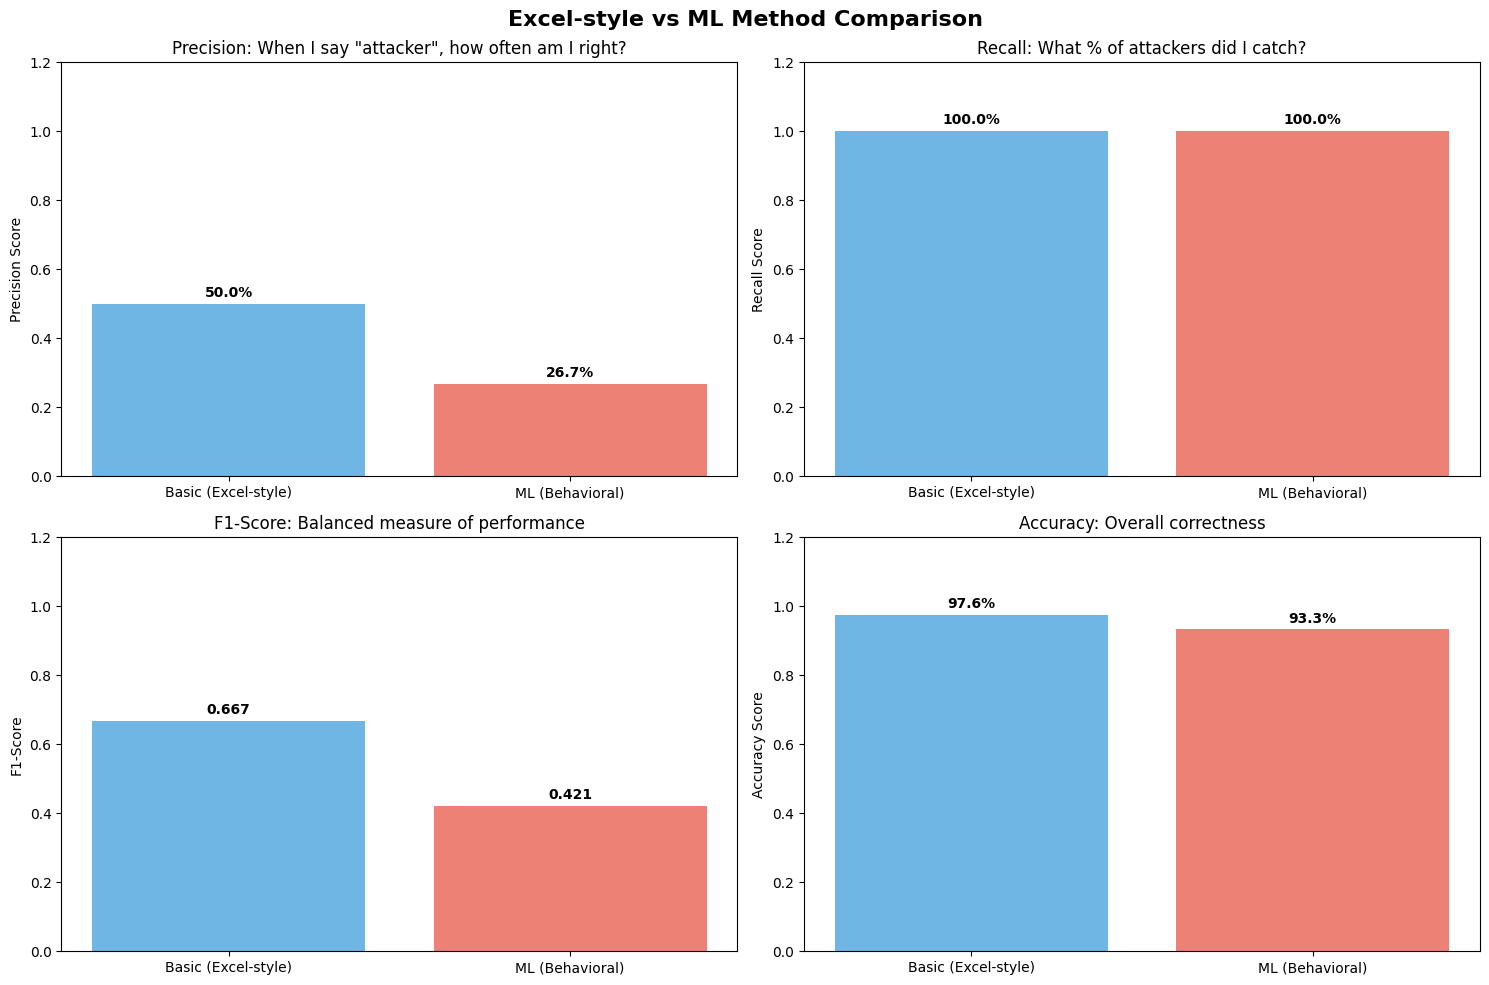

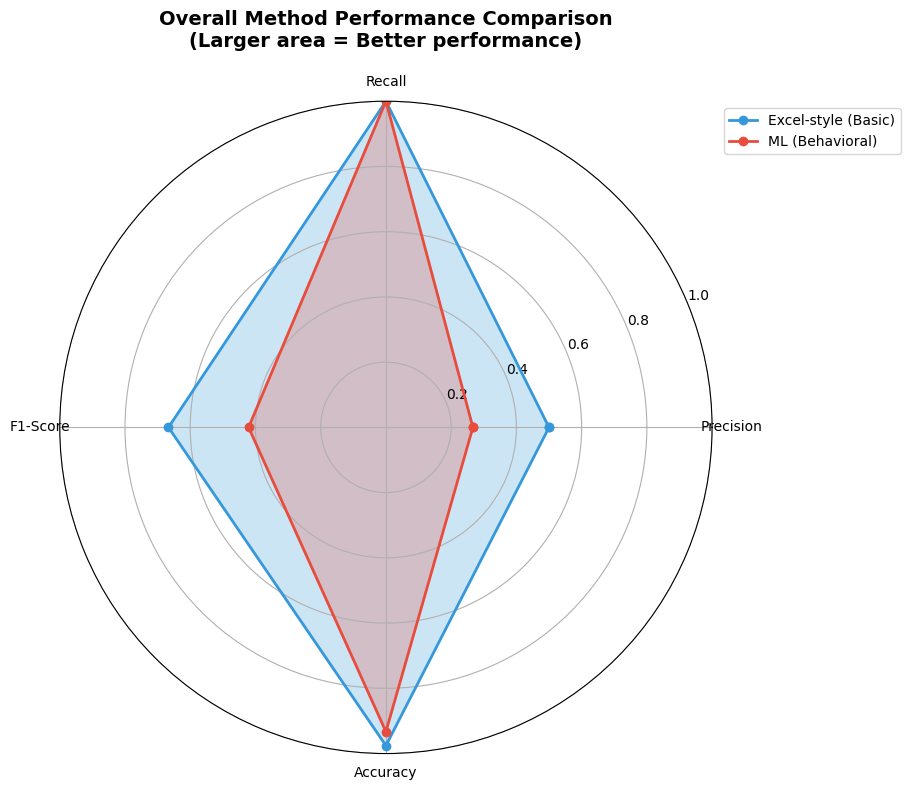

📊 METHOD COMPARISON - MODULE 2
🎯 ACTUAL ATTACK IPs: ['203.0.113.15', '198.51.100.42', '192.0.2.123', '185.199.108.153']
🔍 BASIC METHOD found: ['192.0.2.123', '198.51.100.42', '203.0.113.15', '185.199.108.153', '192.168.1.39', '192.168.3.30', '192.168.2.33', '192.168.3.36']
🤖 ML METHOD found: ['192.0.2.123', '198.51.100.42', '203.0.113.15', '185.199.108.153', '192.168.1.48', '192.168.4.37', '192.168.2.21', '192.168.1.15', '192.168.1.14', '192.168.1.39', '192.168.1.27', '192.168.1.44', '192.168.1.23', '192.168.3.32', '192.168.4.41']

📈 DETECTION RESULTS:
   Basic method: 4/4 correct (100%)
   ML method: 4/4 correct (100%)

❌ FALSE POSITIVES:
   Basic method: 4 false alarms
   ML method: 11 false alarms

⏱️ TIMING COMPARISON:
   Basic method: 0.03 seconds
   ML method: 1.09 seconds
   Speed difference: 37.6x slower

🔍 DETAILED ANALYSIS:
   Basic false positives: ['192.168.3.36', '192.168.2.33', '192.168.1.39', '192.168.3.30']
     192.168.3.36: 20 failed logins (legitimate user with passw

In [35]:
compare_methods_module2()
print_decision_guide()

**Code used to generate the datasets used in these modules may be found below!**

In [36]:
def generate_network_traffic_data(num_records=10000):
    """Generate realistic network traffic data with hidden anomalies"""
    
    # Normal traffic patterns
    normal_sources = [f"192.168.1.{i}" for i in range(10, 100)]
    normal_destinations = [f"10.0.{i}.{j}" for i in range(1, 5) for j in range(10, 50)]
    common_ports = [80, 443, 22, 25, 53, 110, 143, 993, 995]
    
    # Generate timestamps over last 24 hours
    start_time = dt.now() - timedelta(hours=24)
    
    data = []
    
    # Normal traffic (90% of data)
    for _ in range(int(num_records * 0.90)):
        timestamp = start_time + timedelta(seconds=random.randint(0, 86400))
        source = random.choice(normal_sources)
        destination = random.choice(normal_destinations)
        port = random.choice(common_ports)
        bytes_sent = random.randint(64, 1500)
        
        data.append({
            'timestamp': timestamp.strftime('%Y-%m-%d %H:%M:%S'),
            'source_ip': source,
            'destination_ip': destination,
            'destination_port': port,
            'bytes': bytes_sent,
            'protocol': 'TCP'
        })
    
    # Suspicious traffic (10% of data) - More obvious for Excel detection
    suspicious_ips = ['185.220.70.43', '194.233.164.24', '91.234.99.12']
    suspicious_ports = [1337, 4444, 8080, 9999, 31337]
    
    for _ in range(int(num_records * 0.10)):
        timestamp = start_time + timedelta(seconds=random.randint(0, 86400))
        
        if random.random() < 0.4:  # External suspicious IP
            source = random.choice(suspicious_ips)
            destination = random.choice(normal_destinations)
            port = random.choice(suspicious_ports)
            bytes_sent = random.randint(5000, 50000)  # Much larger transfers
        else:  # Internal lateral movement
            source = random.choice(normal_sources)
            destination = random.choice(normal_sources)
            port = random.choice(suspicious_ports)
            bytes_sent = random.randint(2000, 10000)
        
        data.append({
            'timestamp': timestamp.strftime('%Y-%m-%d %H:%M:%S'),
            'source_ip': source,
            'destination_ip': destination,
            'destination_port': port,
            'bytes': bytes_sent,
            'protocol': 'TCP'
        })
    
    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df.sample(frac=1).reset_index(drop=True)  # Shuffle the data

In [37]:
# Generate the dataset
traffic_df = generate_network_traffic_data(500000)
print(f"📊 Generated {len(traffic_df):,} network traffic records")
print(f"📅 Time range: {traffic_df['timestamp'].min()} to {traffic_df['timestamp'].max()}")

# Save to CSV for Excel analysis
traffic_df.to_csv(f"{DATA_DIR}/network_traffic.csv", index=False)
print("💾 Saved to network_traffic.csv")

# Display sample
print("\n🔍 Sample of the data:")
display(traffic_df.head())

📊 Generated 500,000 network traffic records
📅 Time range: 2025-08-08 00:07:12 to 2025-08-09 00:07:12
💾 Saved to network_traffic.csv

🔍 Sample of the data:


,timestamp,source_ip,destination_ip,destination_port,bytes,protocol
0,2025-08-09 00:00:00,192.168.1.70,10.0.4.29,80,593,TCP
1,2025-08-08 06:47:58,192.168.1.86,10.0.2.19,110,416,TCP
2,2025-08-08 05:01:57,192.168.1.30,10.0.1.44,110,1358,TCP
3,2025-08-08 05:09:52,192.168.1.44,10.0.3.30,25,93,TCP
4,2025-08-08 20:38:00,192.168.1.98,10.0.1.40,995,1251,TCP


In [38]:
def generate_auth_logs(num_records=10000):
    """Generate authentication logs with brute force attacks"""
    
    # Normal users
    normal_users = [f"user{i:03d}" for i in range(1, 201)]
    normal_sources = [f"192.168.{i}.{j}" for i in range(1, 5) for j in range(10, 50)]
    
    # Attackers
    attack_sources = ['203.0.113.15', '198.51.100.42', '192.0.2.123']
    attack_targets = ['admin', 'administrator', 'root', 'service', 'guest']
    
    data = []
    start_time = dt.now() - timedelta(hours=6)
    
    # Normal successful logins (80%)
    for _ in range(int(num_records * 0.8)):
        timestamp = start_time + timedelta(seconds=random.randint(0, 21600))
        user = random.choice(normal_users)
        source = random.choice(normal_sources)
        
        data.append({
            'timestamp': timestamp,
            'username': user,
            'source_ip': source,
            'event_type': 'login_success',
            'service': 'ssh'
        })
    
    # Normal failed logins (15%)
    for _ in range(int(num_records * 0.15)):
        timestamp = start_time + timedelta(seconds=random.randint(0, 21600))
        user = random.choice(normal_users)
        source = random.choice(normal_sources)
        
        data.append({
            'timestamp': timestamp,
            'username': user,
            'source_ip': source,
            'event_type': 'login_failure',
            'service': 'ssh'
        })
    
    # Brute force attacks (5%)
    for attacker_ip in attack_sources:
        attack_start = start_time + timedelta(hours=random.randint(1, 4))
        
        # Generate rapid-fire attempts
        for i in range(random.randint(50, 200)):
            timestamp = attack_start + timedelta(seconds=i * random.randint(1, 5))
            user = random.choice(attack_targets + normal_users[:20])
            
            data.append({
                'timestamp': timestamp,
                'username': user,
                'source_ip': attacker_ip,
                'event_type': 'login_failure',
                'service': 'ssh'
            })
    
    return pd.DataFrame(data)

def basic_auth_analysis(df):
    """Basic authentication analysis"""
    
    print("=== BASIC AUTH ANALYSIS ===")
    
    # Failed login attempts by IP
    failed_logins = df[df['event_type'] == 'login_failure']
    ip_failures = failed_logins.groupby('source_ip').size().sort_values(ascending=False)
    
    print("\nTop IPs by failed login attempts:")
    print(ip_failures.head(10))
    
    # Brute force detection (simple threshold)
    brute_force_threshold = 20
    potential_attackers = ip_failures[ip_failures >= brute_force_threshold]
    
    print(f"\nPotential brute force attackers (>={brute_force_threshold} failures):")
    for ip, count in potential_attackers.items():
        ip_data = failed_logins[failed_logins['source_ip'] == ip]
        unique_users = ip_data['username'].nunique()
        time_span = (ip_data['timestamp'].max() - ip_data['timestamp'].min()).total_seconds() / 60
        print(f"  {ip}: {count} failures, {unique_users} users, {time_span:.1f} minutes")
    
    return potential_attackers

def ml_auth_analysis(df):
    """ML-based authentication analysis"""
    
    print("\n=== ML AUTH ANALYSIS ===")
    
    # Create time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    
    # Aggregate by IP and time window (5-minute windows)
    df['time_window'] = df['timestamp'].dt.floor('5min')
    
    features = df.groupby(['source_ip', 'time_window']).agg({
        'username': 'nunique',
        'event_type': lambda x: (x == 'login_failure').sum(),
        'timestamp': 'count'
    }).rename(columns={
        'username': 'unique_users',
        'event_type': 'failures',
        'timestamp': 'total_attempts'
    })
    
    # Calculate failure rate
    features['failure_rate'] = features['failures'] / features['total_attempts']
    features = features.fillna(0)
    
    # Apply clustering to find unusual patterns
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Use DBSCAN to find clusters
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = dbscan.fit_predict(features_scaled)
    
    # Analyze outliers (cluster -1)
    outliers = features[clusters == -1]
    
    print(f"\nOutlier authentication patterns detected: {len(outliers)}")
    
    # Group outliers by IP
    for ip in outliers.index.get_level_values('source_ip').unique()[:5]:
        ip_outliers = outliers[outliers.index.get_level_values('source_ip') == ip]
        print(f"\n{ip}:")
        print(f"  Outlier time windows: {len(ip_outliers)}")
        print(f"  Max failures in 5min: {ip_outliers['failures'].max()}")
        print(f"  Max unique users in 5min: {ip_outliers['unique_users'].max()}")
        print(f"  Max failure rate: {ip_outliers['failure_rate'].max():.2f}")
    
    return outliers

In [39]:
auth_df = generate_auth_logs(10000)
print(f"📊 Generated {len(auth_df):,} authentication records")
print(f"📅 Time range: {auth_df['timestamp'].min()} to {auth_df['timestamp'].max()}")

# Save to CSV
auth_df.to_csv('auth_logs.csv', index=False)
print("💾 Saved to auth_logs.csv")

# Show sample
print("\n🔍 Sample of the data:")
display(auth_df.head())

# Quick overview
print(f"\n📈 Event breakdown:")
print(auth_df['event_type'].value_counts())


📊 Generated 9,980 authentication records
📅 Time range: 2025-08-08 18:07:20.597487 to 2025-08-09 00:07:14.597487
💾 Saved to auth_logs.csv

🔍 Sample of the data:


,timestamp,username,source_ip,event_type,service
0,2025-08-08 21:22:43.597487,user149,192.168.1.12,login_success,ssh
1,2025-08-08 22:31:25.597487,user184,192.168.1.18,login_success,ssh
2,2025-08-08 18:18:36.597487,user082,192.168.3.16,login_success,ssh
3,2025-08-08 20:28:04.597487,user058,192.168.1.12,login_success,ssh
4,2025-08-08 21:05:15.597487,user105,192.168.3.49,login_success,ssh



📈 Event breakdown:
event_type
login_success    8000
login_failure    1980
Name: count, dtype: int64
